In [1]:
%pip install -e "/home/callum/projects/evo-ued[examples]"
# then restart the kernel

Obtaining file:///home/callum/projects/evo-ued
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for jaxued (pyproject.toml) ... done
  Created wheel for jaxued: filename=jaxued-0.0.1-0.editable-py3-none-any.whl size=4788 sha256=71ce1c4386be357ecda6342aac83933ff7752d83ce3def5fcea38e5e04ee3a8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-y5yayxac/wheels/ee/59/3a/d13b040ff06b61f61846f3c06af3e0515b6636ca8d225966a3
Successfully built jaxued
  Attempting uninstall: jaxued
    Found existing installation: jaxued 0.0.1
    Uninstalling jaxued-0.0.1:
      Successfully uninstalled jaxued-0.0.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))


In [3]:
from scripts.utils_wandb import (
    load_runname_group_map_from_file,
    collect_multi_histories_from_run_mapping,
)

ENTITY = "callumrlawson-pibbss"
PROJECT = "JAXUED_TEST"
STEP = "num_updates"
METRIC_RETURN = "return/mean"  # or e.g. "return/StandardMaze3"
METRIC_SOLVE = "solve_rate/mean"
CFG_PATH = "/home/callum/projects/evo-ued/config/eval250_updates30k_lr1e-4.json"
SAMPLES = 100_000 # no thinning of samples

# 1) Grouping defined by repo config (run_name -> algo)
runmap = load_runname_group_map_from_file(CFG_PATH)

# 2) Fetch both metrics in one pass, then subset into value frames
df_all = collect_multi_histories_from_run_mapping(
    ENTITY, PROJECT, runmap,
    step_key=STEP, metric_keys=[METRIC_RETURN, METRIC_SOLVE],
    samples=SAMPLES   # set None for full history
)

df_return = (
    df_all[df_all["metric"] == METRIC_RETURN]
    .drop(columns=["metric"])
    .reset_index(drop=True)
)

df_solve = (
    df_all[df_all["metric"] == METRIC_SOLVE]
    .drop(columns=["metric"])
    .reset_index(drop=True)
)

# Quick sanity check
print(df_return.groupby("group")["run_id"].nunique().sort_values())

/home/callum/projects/evo-ued/scripts/utils_wandb.py:811: UserWarning: Duplicate runs for 'dr_softmin_eval250_seed9_30000a'. Using 5z2kz0cr (score=30000.0). Others: 5494bqdu:2000.0, g8ga87vx:2000.0
  warnings.warn(
/home/callum/projects/evo-ued/scripts/utils_wandb.py:811: UserWarning: Duplicate runs for 'dr_baseline_eval250_seed9_30000a'. Using z2kg4331 (score=30000.0). Others: 4wxgkyo7:2000.0, tddvc36j:2000.0
  warnings.warn(


group
PLR (baseline)         5
ACCEL                 10
DR (baseline)         10
DR (evolutionary)     10
PLR (evolutionary)    10
Name: run_id, dtype: int64


In [4]:
from scripts.utils_wandb import collect_histories_from_run_mapping
df = collect_histories_from_run_mapping(
    ENTITY, PROJECT, runmap,
    step_key="num_updates", metric_key=METRIC_SOLVE,
    attach_config_keys=["lr"]  # or "lr" depending on your config layout
)

/home/callum/projects/evo-ued/scripts/utils_wandb.py:811: UserWarning: Duplicate runs for 'dr_softmin_eval250_seed9_30000a'. Using 5z2kz0cr (score=30000.0). Others: 5494bqdu:2000.0, g8ga87vx:2000.0
  warnings.warn(
/home/callum/projects/evo-ued/scripts/utils_wandb.py:811: UserWarning: Duplicate runs for 'dr_baseline_eval250_seed9_30000a'. Using z2kg4331 (score=30000.0). Others: 4wxgkyo7:2000.0, tddvc36j:2000.0
  warnings.warn(


In [5]:
df_return.groupby("group").count()


,num_updates,value,run_id
group,,,
ACCEL,1200,1200,1200
DR (baseline),1200,1200,1200
DR (evolutionary),1200,1200,1200
PLR (baseline),600,600,600
PLR (evolutionary),1200,1200,1200


In [6]:
from scripts.training_analyses import (
    aggregate_training_iqr, aggregate_worst_case,
)

df_dict = {
    "return": df_return,
    "solve rate": df_solve,
}

agg_dict = {}
for metric, df in df_dict.items():
    agg_q = aggregate_training_iqr(df, STEP)
    agg_w = aggregate_worst_case(df, STEP)
    agg_dict[metric] = {
        "iqr": agg_q,
        "worst_case": agg_w,
    }

In [7]:
from scripts.training_plots import make_algorithm_palette, plot_training_runs
ALG_PALETTE = make_algorithm_palette(sorted(df_return["group"].unique().tolist()))

In [8]:
agg_dict["return"]["iqr"].head()

,group,num_updates,q_low,q_center,q_high,count
0,ACCEL,250,0.000082,0.000272,0.000357,10
1,ACCEL,500,0.000865,0.000936,0.001164,10
2,ACCEL,750,0.003866,0.005051,0.007383,10
3,ACCEL,1000,0.006154,0.013000,0.017582,10
4,ACCEL,1250,0.007366,0.013188,0.025017,10


<Axes: xlabel='update', ylabel='solve rate'>

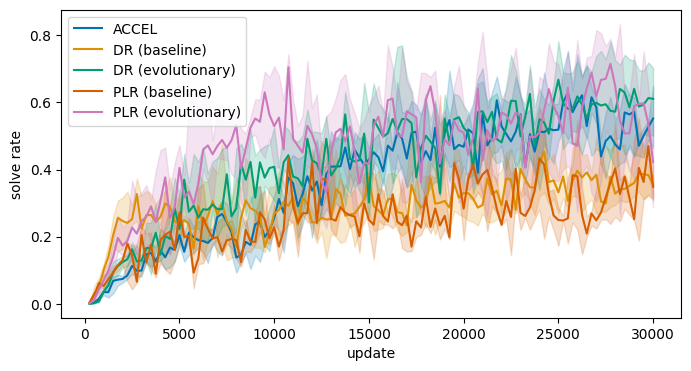

In [9]:
# y_label = "return"
# plot_type = "iqr"
# plot_training_runs(agg_dict[y_label][plot_type], step_key=STEP, palette_map=ALG_PALETTE, y_label=y_label)
# plot_type = "worst_case"
# plot_training_runs(agg_dict[y_label][plot_type], step_key=STEP, palette_map=ALG_PALETTE, y_label=y_label)

y_label = "solve rate"
plot_type = "iqr"
plot_training_runs(agg_dict[y_label][plot_type], step_key=STEP, palette_map=ALG_PALETTE, y_label=y_label)
# plot_type = "worst_case"
# plot_training_runs(agg_dict[y_label][plot_type], step_key=STEP, palette_map=ALG_PALETTE, y_label=y_label)


In [10]:
from scripts.training_analyses import final_values_per_run, summarize_final_values

# 1) Extract each run's final evaluation solve rate (at max STEP within that run)
per_run_final = final_values_per_run(df_solve, STEP, extra_cols=["lr"])

# 2) Summarize per algorithm and show as a 1-row wide table of "mean ± std"
group_order = sorted(df_solve["group"].unique().tolist())
solve_table = summarize_final_values(per_run_final, group_order=group_order, decimals=2, as_wide_formatted=True)

# Optional: pretty print with group columns ordered consistently
solve_table = solve_table[[g for g in group_order if g in solve_table.columns]]
display(solve_table)

,ACCEL,DR (baseline),DR (evolutionary),PLR (baseline),PLR (evolutionary)
0,0.58 ± 0.16,0.36 ± 0.07,0.59 ± 0.17,0.37 ± 0.09,0.43 ± 0.19


In [11]:
from scripts.training_analyses import check_update_step_alignment

# df_solve is your long-form history for "solve_rate/mean"
steps = check_update_step_alignment(df_solve, STEP, per_group=True, atol=0.0)
display(steps.head())  # shows [group, run_id, max_step]

,group,run_id,max_step
0,ACCEL,24bmpp6v,30000
1,ACCEL,6ztujrc1,30000
2,ACCEL,b9vuk5b0,30000
3,ACCEL,bh6pk83k,30000
4,ACCEL,dzd3prg7,30000


# Learning rates

In [12]:
CFG_PATH_SLOW = "/home/callum/projects/evo-ued/config/eval250_updates30k_lr5e-5.json"

runmap_slow = load_runname_group_map_from_file(CFG_PATH_SLOW)

df_slow = collect_multi_histories_from_run_mapping(
    ENTITY, PROJECT, runmap_slow,
    step_key=STEP, metric_keys=[METRIC_RETURN, METRIC_SOLVE],
    samples=SAMPLES,   # set None for full history
)

df_return_slow = (
    df_slow[df_slow["metric"] == METRIC_RETURN]
    .drop(columns=["metric"])
    .reset_index(drop=True)
)

df_solve_slow = (      
    df_slow[df_slow["metric"] == METRIC_SOLVE]
    .drop(columns=["metric"])
    .reset_index(drop=True)
)

print(df_return_slow.groupby("group")["run_id"].nunique().sort_values())

group
ACCEL                5
DR (baseline)        5
DR (evolutionary)    5
Name: run_id, dtype: int64


In [13]:
CFG_PATH_FAST = "/home/callum/projects/evo-ued/config/eval250_updates30k_lr3e-4.json"

runmap_fast = load_runname_group_map_from_file(CFG_PATH_FAST)

df_fast = collect_multi_histories_from_run_mapping(
    ENTITY, PROJECT, runmap_fast,
    step_key=STEP, metric_keys=[METRIC_RETURN, METRIC_SOLVE],
    samples=SAMPLES,   # set None for full history
)

df_return_fast = (
    df_fast[df_fast["metric"] == METRIC_RETURN]
    .drop(columns=["metric"])
    .reset_index(drop=True)
)

df_solve_fast = (
    df_fast[df_fast["metric"] == METRIC_SOLVE]
    .drop(columns=["metric"])
    .reset_index(drop=True)
)

print(df_return_fast.groupby("group")["run_id"].nunique().sort_values())

/home/callum/projects/evo-ued/scripts/utils_wandb.py:811: UserWarning: Duplicate runs for 'dr_baseline_eval250_seed4_lr3e-4_30000c'. Using jeltfl0l (score=30000.0). Others: g78x8x0a:28500.0
  warnings.warn(
/home/callum/projects/evo-ued/scripts/utils_wandb.py:811: UserWarning: Duplicate runs for 'dr_baseline_eval250_seed3_lr3e-4_30000c'. Using vfxhks9v (score=30000.0). Others: dzy4ziqj:25000.0
  warnings.warn(


group
ACCEL                5
DR (baseline)        5
DR (evolutionary)    5
Name: run_id, dtype: int64


In [14]:
from scripts.training_analyses import (
    aggregate_training_iqr, aggregate_worst_case,
)

df_dict_slow = {
    "return": df_return_slow,
    "solve rate": df_solve_slow,
}

agg_dict_slow = {}
for metric, df in df_dict_slow.items():
    agg_q = aggregate_training_iqr(df, STEP)
    agg_w = aggregate_worst_case(df, STEP)
    agg_dict_slow[metric] = {
        "iqr": agg_q,
        "worst_case": agg_w,
    }


<Axes: xlabel='update', ylabel='solve rate'>

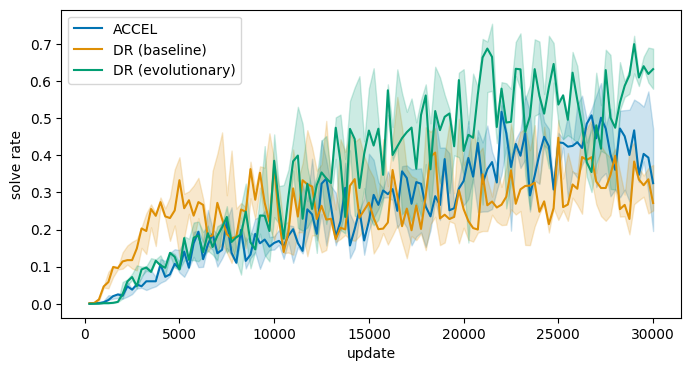

In [15]:
agg_dict_plot = agg_dict_slow 

# y_label = "return"
# plot_type = "iqr"
# plot_training_runs(agg_dict_plot[y_label][plot_type], step_key=STEP, palette_map=ALG_PALETTE, y_label=y_label)
# plot_type = "worst_case"
# plot_training_runs(agg_dict_plot[y_label][plot_type], step_key=STEP, palette_map=ALG_PALETTE, y_label=y_label)

y_label = "solve rate"
plot_type = "iqr"
plot_training_runs(agg_dict_plot[y_label][plot_type], step_key=STEP, palette_map=ALG_PALETTE, y_label=y_label)
# plot_type = "worst_case"
# plot_training_runs(agg_dict_plot[y_label][plot_type], step_key=STEP, palette_map=ALG_PALETTE, y_label=y_label)


In [16]:


df_dict_fast = {
    "return": df_return_fast,
    "solve rate": df_solve_fast,
}

agg_dict_fast = {}
for metric, df in df_dict_fast.items():
    agg_q = aggregate_training_iqr(df, STEP)
    agg_w = aggregate_worst_case(df, STEP)
    agg_dict_fast[metric] = {
        "iqr": agg_q,
        "worst_case": agg_w,
    }

<Axes: xlabel='update', ylabel='solve rate'>

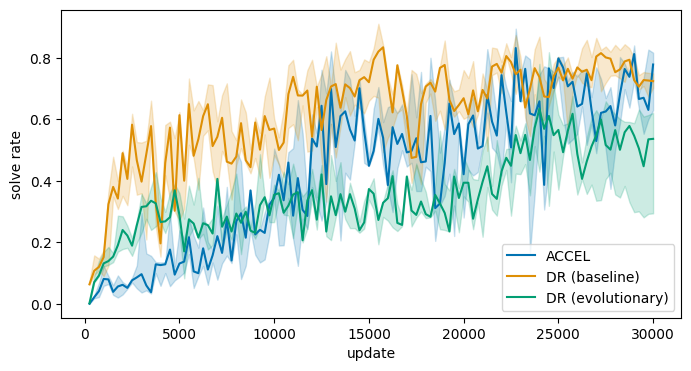

In [17]:
add_dict_plot = agg_dict_fast

# y_label = "return"
# plot_type = "iqr"
# plot_training_runs(add_dict_plot[y_label][plot_type], step_key=STEP, palette_map=ALG_PALETTE, y_label=y_label)
# plot_type = "worst_case"
# plot_training_runs(add_dict_plot[y_label][plot_type], step_key=STEP, palette_map=ALG_PALETTE, y_label=y_label)

y_label = "solve rate"
plot_type = "iqr"
plot_training_runs(add_dict_plot[y_label][plot_type], step_key=STEP, palette_map=ALG_PALETTE, y_label=y_label)
# plot_type = "worst_case"
# plot_training_runs(add_dict_plot[y_label][plot_type], step_key=STEP, palette_map=ALG_PALETTE, y_label=y_label)


# Learning Rates Sweep

In [18]:
from scripts.utils_wandb import collect_histories_from_run_mapping
CFG_PATH_LR_SWEEP = "/home/callum/projects/evo-ued/config/updates30k_lr_sweep.json"

runmap_lr_sweep = load_runname_group_map_from_file(CFG_PATH_LR_SWEEP)

df = collect_histories_from_run_mapping(
    ENTITY, PROJECT, runmap_lr_sweep,
    step_key="num_updates", metric_key=METRIC_SOLVE,
    attach_config_keys=["lr"],
    samples=SAMPLES,   # important: fetch rows
    refresh=True
)
print(df.shape)
df.head()

/home/callum/projects/evo-ued/scripts/utils_wandb.py:811: UserWarning: Duplicate runs for 'dr_baseline_eval80_seed13_lr2e-4_30000c'. Using kzw48m1m (score=30000.0). Others: z6u0m3xg:27250.0
  warnings.warn(
/home/callum/projects/evo-ued/scripts/utils_wandb.py:811: UserWarning: Duplicate runs for 'dr_baseline_eval250_seed4_lr3e-4_30000c'. Using jeltfl0l (score=30000.0). Others: g78x8x0a:28500.0
  warnings.warn(
/home/callum/projects/evo-ued/scripts/utils_wandb.py:811: UserWarning: Duplicate runs for 'dr_baseline_eval250_seed3_lr3e-4_30000c'. Using vfxhks9v (score=30000.0). Others: dzy4ziqj:25000.0
  warnings.warn(
/home/callum/projects/evo-ued/scripts/utils_wandb.py:811: UserWarning: Duplicate runs for 'dr_softmin_eval250_seed9_30000a'. Using 5z2kz0cr (score=30000.0). Others: 5494bqdu:2000.0, g8ga87vx:2000.0
  warnings.warn(
/home/callum/projects/evo-ued/scripts/utils_wandb.py:811: UserWarning: Duplicate runs for 'dr_baseline_eval250_seed9_30000a'. Using z2kg4331 (score=30000.0). Others

(9720, 5)


,num_updates,value,run_id,group,lr
0,250,0.000000,ehw7400m,ACCEL,0.0006
1,500,0.031250,ehw7400m,ACCEL,0.0006
2,750,0.081250,ehw7400m,ACCEL,0.0006
3,1000,0.085938,ehw7400m,ACCEL,0.0006
4,1250,0.153125,ehw7400m,ACCEL,0.0006


In [19]:
per_run_final = final_values_per_run(df, STEP, extra_cols=["lr"])
per_run_final.head()

,group,run_id,step,value,lr
0,DR (evolutionary),0d8eu2lt,30000,0.578125,0.000600
1,ACCEL,1q6h07v4,30000,0.810938,0.000075
2,ACCEL,24bmpp6v,30000,0.403500,0.000100
3,ACCEL,28iebl4p,30000,0.739062,0.000200
4,ACCEL,30wcz63p,30000,0.778000,0.000300


Multiple values per (lr, group) detected; using median per pair. Aggregated 9 pairs.


Text(0.5, 1.0, 'Performance vs Learning Rate')

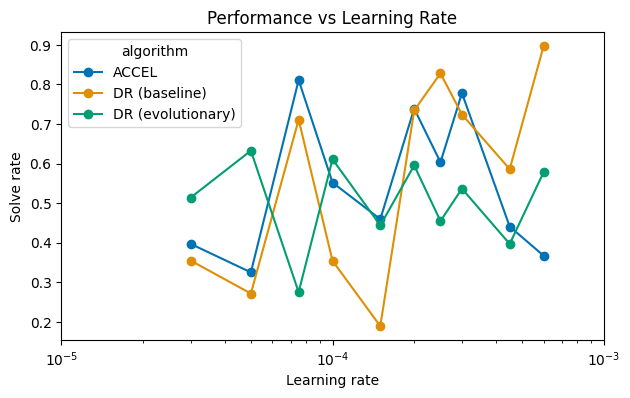

In [ ]:
from scripts.training_plots import plot_hyperparam_vs_value

ax = plot_hyperparam_vs_value(
    per_run_final,
    hp_col="lr",
    value_col="value",
    log_x=True,
    x_label="Learning rate",
    y_label="Solve rate",
    label_fmt="{group}",
)
ax.set_title("Performance vs Learning Rate")